In [1]:
import numpy as np
from pyeeg import bin_power

import matplotlib.pyplot as plt
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
import pandas as pd
import pickle
import os
from IPython import display

In [2]:
from sys import path
path.append('../')
from utils.average_classifier import *
from utils.split_features_and_labels import split_features_and_labels_interfaces

In [3]:
channels = "Fp1,Fp2,Fz,Cz,T3,T4,Pz,Oz".split(',')
channels_to_use = 'Fp1,Fp2,T3,T4'.split(',') 
electrodes_idx = np.asarray([channels.index(e) for e in channels_to_use])
channels = channels_to_use

sampling_rate = 250
seconds_to_predict = 5

In [4]:
EEG = np.load('INTERFACES/EEG_ICA.npy')
label_arousal = np.load('INTERFACES/label/arousal.npy')
label_valence = np.load('INTERFACES/label/valence.npy')

In [5]:
bands = ['3-7','8-13','14-29','30-47']
feature_names = np.asarray([[str(bands[x]) + '|' + e for x in range(len(bands))] for e in channels], dtype='object')
feature_names = np.ravel(feature_names)
print(feature_names)

['3-7|Fp1' '8-13|Fp1' '14-29|Fp1' '30-47|Fp1' '3-7|Fp2' '8-13|Fp2'
 '14-29|Fp2' '30-47|Fp2']


In [6]:
importance_dfs = []

In [7]:
use_last_npy = False
feature_dump_file = 'interfaces_features_4.npy'
EEG = EEG[:, electrodes_idx]

splitted_features, splitted_labels_arousal = split_features_and_labels_interfaces(EEG, label_arousal, sampling_rate, seconds_to_predict)
splitted_features, splitted_labels_valence = split_features_and_labels_interfaces(EEG, label_valence, sampling_rate, seconds_to_predict)

if use_last_npy and os.path.exists(feature_dump_file):
    final_features = np.load(feature_dump_file)
else:
    temp_reshaped = np.reshape(splitted_features, [splitted_features.shape[0]*splitted_features.shape[1]*splitted_features.shape[2], splitted_features.shape[3]])
    powers = []
    for i, sample in enumerate(temp_reshaped):
        if i % 3000 == 0:
            print('Progress: %s' % (str(np.round(i/len(temp_reshaped), 2))))
        powers.append(bin_power(sample, [0, 999999], Fs=sampling_rate))

    powers = np.asarray(powers)
    powers = np.reshape(powers[:, 0, :], splitted_features.shape[:3])
    powers = np.reshape(powers, [powers.shape[0], powers.shape[1] * powers.shape[2]])
    final_features = powers

    final_features.dump(feature_dump_file)


Progress: 0.0
Progress: 0.05
Progress: 0.11
Progress: 0.16
Progress: 0.21
Progress: 0.26
Progress: 0.32
Progress: 0.37
Progress: 0.42
Progress: 0.48
Progress: 0.53
Progress: 0.58
Progress: 0.63
Progress: 0.69
Progress: 0.74
Progress: 0.79
Progress: 0.85
Progress: 0.9
Progress: 0.95


In [8]:
importance_dfs = []
for classification_type in ['valence', 'arousal']:
    print('-------------------------------------------------------------------------')
    print(classification_type)
    final_features = powers
    if classification_type == 'valence':
        labels=splitted_labels_valence
    elif classification_type == 'arousal':
        labels=splitted_labels_arousal
    kf = KFold(n_splits=10, shuffle=True)
    i = 0
    regressors = []
    importances =[]
    all_predictions_arousal = np.zeros((final_features.shape[0], ))
    for train_index, test_index in kf.split(final_features):
        x_train = final_features[train_index]
        y_train = labels[train_index]
        x_test = final_features[test_index]
        y_test = labels[test_index]

        xgb =  XGBClassifier(eval_metric='mlogloss')
        xgb.fit(x_train, y_train)
        

        print('Fold number ' + str(i))
        y_pred = xgb.predict(x_train)
        print('Train F1: ' + str(f1_score(y_train, y_pred)))
        y_pred = xgb.predict(x_test)
        print('Test F1: ' + str(f1_score(y_test, y_pred)))
        importances.append(xgb.feature_importances_)
        all_predictions_arousal[test_index] = y_pred
        regressors.append(xgb)
        i += 1
    print(classification_report(labels,all_predictions_arousal))


    df = pd.DataFrame()
    df['feature_name'] = feature_names
    df['mean_importances'] = np.sum(np.asarray(importances), axis=0)
    df['electrode'] = [x.split('|')[1] for x in df['feature_name']]
    importance_dfs.append(df)

    average_predictor = AverageXGBClassifier(regressors, feature_names)
    print('This score should be high because of overfitting, but not low')
    print(average_predictor.predict(final_features).shape)

    print(f1_score(labels, average_predictor.predict(final_features)))
    pickle.dump(average_predictor,open('average_classifier_%s.pkl' % (classification_type), 'wb'))



-------------------------------------------------------------------------
valence


C:\Users\somat\miniconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fold number 0
Train F1: 0.9252905368013281
Test F1: 0.5821917808219178
Fold number 1
Train F1: 0.9319740500463393
Test F1: 0.5804311774461027
Fold number 2
Train F1: 0.932367149758454
Test F1: 0.5942275042444822
Fold number 3
Train F1: 0.92132311717436
Test F1: 0.5918367346938774
Fold number 4
Train F1: 0.931893079458074
Test F1: 0.5890652557319224
Fold number 5
Train F1: 0.9261469600895189
Test F1: 0.5936981757877281
Fold number 6
Train F1: 0.9359044995408631
Test F1: 0.6
Fold number 7
Train F1: 0.9241021843761569
Test F1: 0.5799011532125206
Fold number 8
Train F1: 0.9303855289603508
Test F1: 0.6091549295774648
Fold number 9
Train F1: 0.9300608968444364
Test F1: 0.5547703180212014
              precision    recall  f1-score   support

           0       0.69      0.74      0.71      4026
           1       0.62      0.56      0.59      3069

    accuracy                           0.66      7095
   macro avg       0.65      0.65      0.65      7095
weighted avg       0.66      0.66    

KeyboardInterrupt: 

In [ ]:
importance_dfs[0].sort_values('mean_importances', ascending = False)

,feature_name,mean_importances,electrode
2,14-29|Fp1,1.567244,Fp1
7,30-47|Fp2,1.315578,Fp2
3,30-47|Fp1,1.306292,Fp1
4,3-7|Fp2,1.240075,Fp2
6,14-29|Fp2,1.218384,Fp2
5,8-13|Fp2,1.128395,Fp2
0,3-7|Fp1,1.114455,Fp1
1,8-13|Fp1,1.109576,Fp1


In [ ]:
importance_dfs[1].sort_values('mean_importances', ascending = False)

,feature_name,mean_importances,electrode
4,3-7|Fp2,1.440364,Fp2
7,30-47|Fp2,1.384393,Fp2
3,30-47|Fp1,1.334906,Fp1
2,14-29|Fp1,1.301428,Fp1
6,14-29|Fp2,1.235309,Fp2
5,8-13|Fp2,1.144721,Fp2
1,8-13|Fp1,1.081118,Fp1
0,3-7|Fp1,1.077761,Fp1


3-7|Fp1


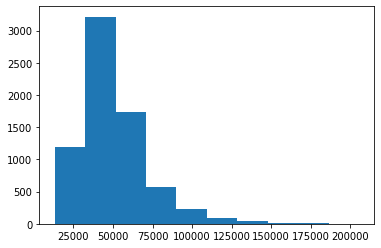

8-13|Fp1


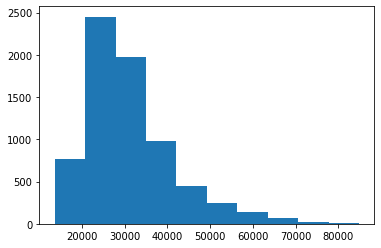

14-29|Fp1


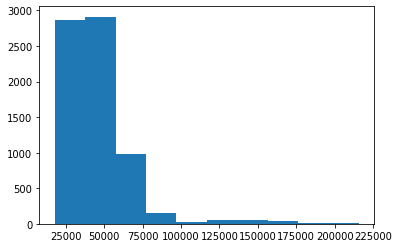

30-47|Fp1


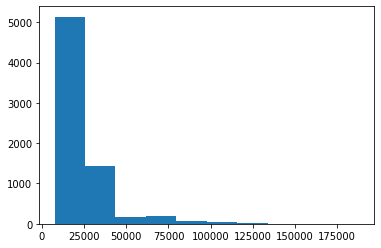

3-7|Oz


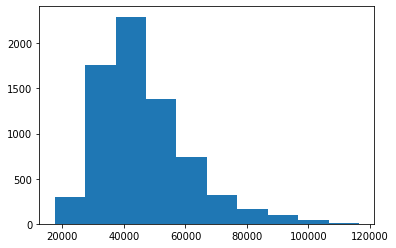

8-13|Oz


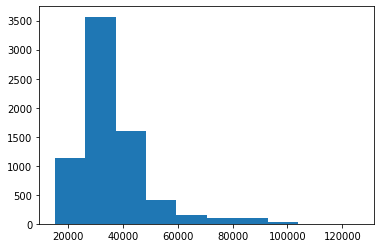

14-29|Oz


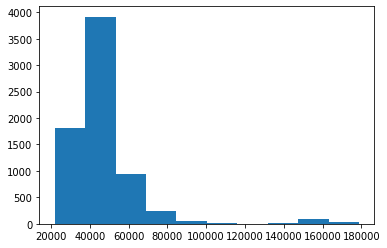

30-47|Oz


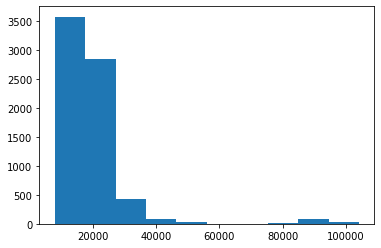

3-7|Fp2


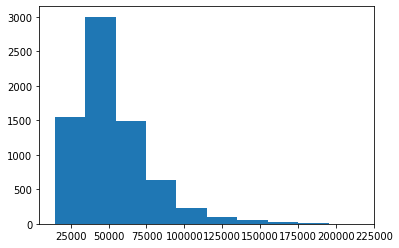

8-13|Fp2


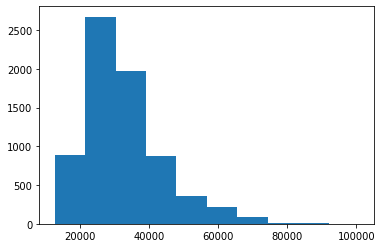

14-29|Fp2


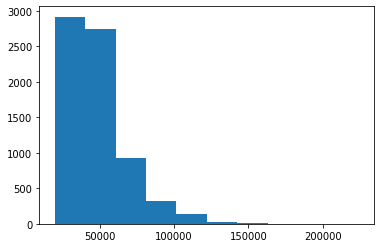

30-47|Fp2


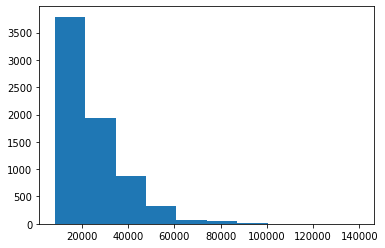

3-7|T4


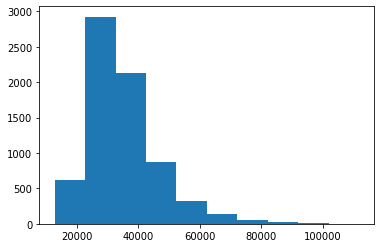

8-13|T4


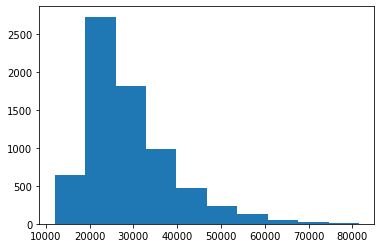

14-29|T4


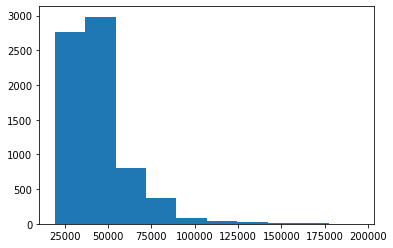

30-47|T4


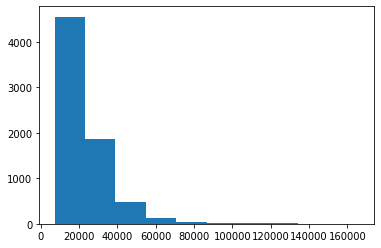

In [ ]:
for i in range(final_features.shape[-1]):
    print(feature_names[i])
    plt.hist(final_features[:,i])
    plt.show()